# SENG 474 A02: Assignment 2
## Logistic Regression, SVM, and k-Fold Cross Validation
Sean McAuliffe, V00913346  
February 27, 2023


In [5]:
# Envrionment Setup
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression as LR
from sklearn.svm import SVC
# from sklearn.model_selection import train_test_split
# from ipynb.fs.full.kfcv_a2 import kfold_cv
from utils import mnist_reader
import warnings
from sklearn.exceptions import ConvergenceWarning
from math import pow

# Data Filtering for Class 0 and 6, Normalization via Rescaling

In [6]:
# Data Import & Preprocessing
X_train, y_train = mnist_reader.load_mnist('data/fashion', kind='train')
X_test, y_test = mnist_reader.load_mnist('data/fashion', kind='t10k')

# Filter out examples which are not class 0 or 6
X_train = X_train[(y_train == 0) | (y_train == 6)]
y_train = y_train[(y_train == 0) | (y_train == 6)]
X_test = X_test[(y_test == 0) | (y_test == 6)]
y_test = y_test[(y_test == 0) | (y_test == 6)]

# Keep just the first 2400 examples
X_train = X_train[:2400]
y_train = y_train[:2400]

# np.random.seed(0)
# idx = np.random.choice(X_train.shape[0], 2400, replace=False)
# X_train = X_train[idx]
# y_train = y_train[idx]

print("X_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)
print("X_test shape: ", X_test.shape)
print("y_test shape: ", y_test.shape)

# Normalization Option 1: rescale so the examples lie in range [0, 1]
X_train = X_train / 255
X_test = X_test / 255

# Normalization Option 2: ensure each feature has unit norm
# X_train = X_train / np.linalg.norm(X_train, axis=1, keepdims=True)
# X_test = X_test / np.linalg.norm(X_test, axis=1, keepdims=True)

X_train shape:  (2400, 784)
y_train shape:  (2400,)
X_test shape:  (2000, 784)
y_test shape:  (2000,)


# *k*-Fold Cross Validation Implementation

In [7]:
def kfold_cv(X, y, k, model):
    # Split the data into k folds
    X_folds = np.array_split(X, k)
    y_folds = np.array_split(y, k)

    accuracies = []

    for i in range(k):
        # Create training and validation sets
        # Training sets contain every fold except the ith
        X_train = np.concatenate(X_folds[:i] + X_folds[i+1:])
        y_train = np.concatenate(y_folds[:i] + y_folds[i+1:])
        # Validation set is the ith fold
        X_validation = X_folds[i]
        y_validation = y_folds[i]
        # Train the model
        model.fit(X_train, y_train)

        # Evaluate the model
        accuracies.append(model.score(X_validation, y_validation))

    return 1 - np.average(np.array(accuracies))

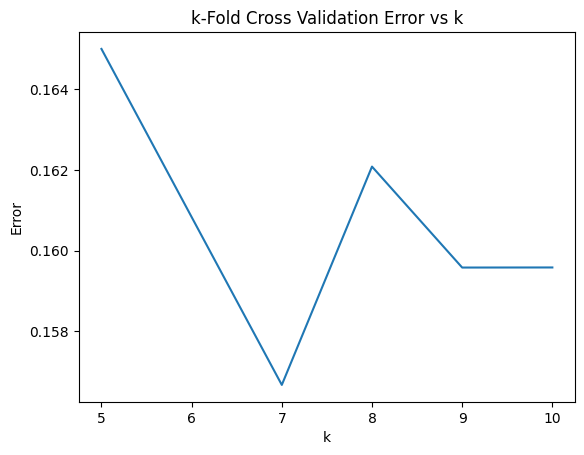

In [8]:
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# Logistic Regression
# Train a logistic regression classifier on the training data
# and evaluate its accuracy using k-fold cross validation
# with k=5 through k=10.

# A Linear Regression Classifier with default parameters
lrc = LR(penalty='l2',
         dual=False,
         tol=0.0001,
         C=1.0,
         fit_intercept=True,
         intercept_scaling=1,
         class_weight=None,
         random_state=None,
         solver='lbfgs',
         max_iter=100,
         multi_class='auto',
         verbose=0,
         warm_start=False,
         n_jobs=None,
         l1_ratio=None)

# k-fold cross validation, we will test k from 5 to 10
# and plot the accuracy vs k, we'll choose the best k
# to use in future model selection experiments
accuracies = []
for k in range(5, 11):
    accuracies.append(kfold_cv(X_train, y_train, k, lrc))

# Plot the accuracies
plt.plot(range(5, 11), accuracies)
plt.xlabel('k')
plt.ylabel('Error')
plt.title('k-Fold Cross Validation Error vs k')
plt.show()

We will use 5-fold cross validation in future experiments. The differences between k-values are not exteme enough to warrant the additional computation, and 5 yields the best result in this simple case with the default values.

# Experiment 1: Logistic Regression

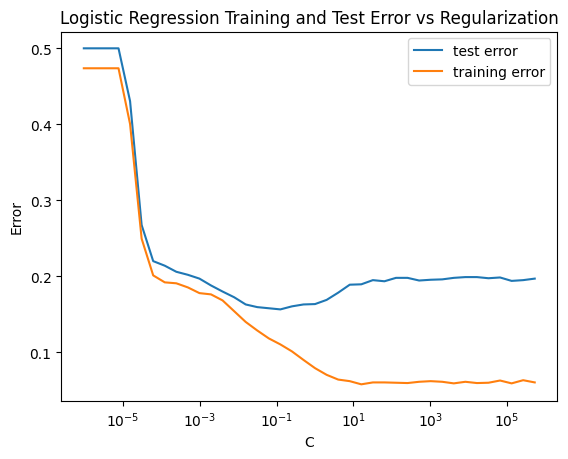

In [9]:
# Experiment 1: Effects of Regularization Parameter, C
# This experiment will search for the best C-value, creating a
# linear regression model for each C-value and evaluating its
# accuracy on training and test data.
# We will plot the accuracy vs C-value and choose the best C-value,
# a wide range of C-values will be tested.

C_naught = 1
alpha = 2

# Create a list of C-values to test
C_values = [C_naught * pow(alpha, i) for i in range(-20, 20)]
models = []

for c in C_values:
    lrc = LR(penalty='l2',
            dual=False,
            tol=0.0001,
            C=c,
            fit_intercept=True,
            intercept_scaling=1,
            class_weight=None,
            random_state=None,
            solver='lbfgs',
            max_iter=100,
            multi_class='auto',
            verbose=0,
            warm_start=False,
            n_jobs=None,
            l1_ratio=None)
    lrc.fit(X_train, y_train)
    models.append(lrc)


# Score each of the models 
training_error = []
test_error = []
for model in models:
    test_error.append(1 - model.score(X_test, y_test))
    training_error.append(1 - model.score(X_train, y_train))

# Plot the accuracies
plt.plot(C_values, test_error, label='test error')
plt.plot(C_values, training_error, label='training error')
plt.xscale('log')
plt.xlabel('C')
plt.ylabel('Error')
plt.title('Logistic Regression Training and Test Error vs Regularization')
plt.legend()
plt.show()

# Experiment 2: Support Vector Machines

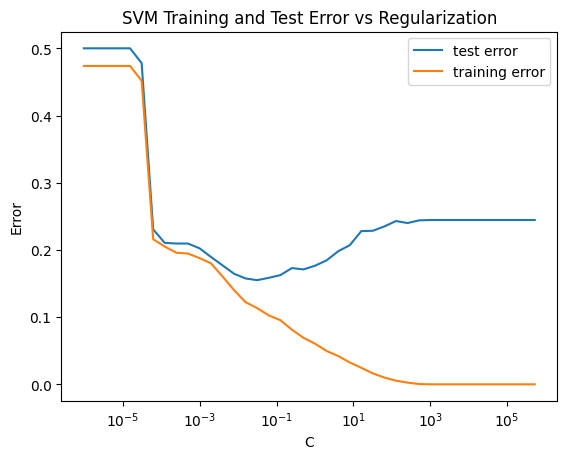

In [13]:
# Experiment 2: Effects of Regularization on Linear Kernel SVM
# This experiment will search for the best C-value, creating a
# linear kernel SVM model for each C-value and evaluating its
# accuracy using k-fold cross on training and test sets.

C_naught = 1
alpha = 2

# Create a list of C-values to test
C_values = [C_naught * pow(alpha, i) for i in range(-20, 20)]
models = []

for c in C_values:
    svmc = SVC(C=c,
               kernel='linear',
               degree=3,
               gamma='scale',
               coef0=0.0,
               shrinking=True,
               probability=False,
               tol=0.001,
               cache_size=200,
               class_weight=None,
               verbose=False,
               max_iter=-1,
               decision_function_shape='ovr',
               break_ties=False,
               random_state=None)
    svmc.fit(X_train, y_train)
    models.append(svmc)

# Score each of the models
training_error = []
test_error = []
for model in models:
    test_error.append(1 - model.score(X_test, y_test))
    training_error.append(1 - model.score(X_train, y_train))

# Plot the accuracies
plt.plot(C_values, test_error, label='test error')
plt.plot(C_values, training_error, label='training error')
plt.xscale('log')
plt.xlabel('C')
plt.ylabel('Error')
plt.title('SVM Training and Test Error vs Regularization')
plt.legend()
plt.show()

# Experiment 3: Finding Optimal Regularization Parameter using K-Fold Cross Validation

Logistic Regression Minimum Error:  0.15083333333333326
Logistic Regression C Value:  0.0625
SVM Minimum Error:  0.15291666666666648
SVM C Value:  0.03125


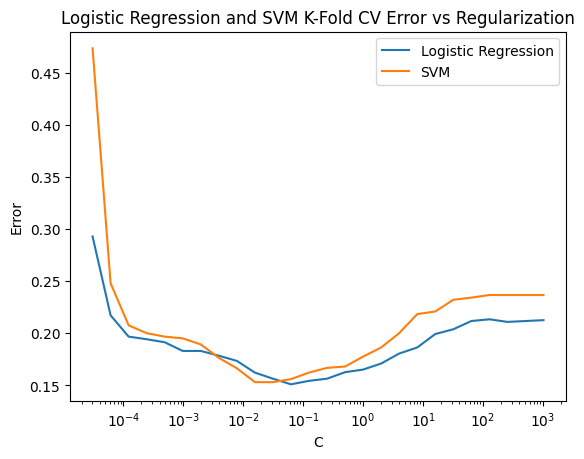

In [15]:
# Experiment 3: Using K-fold CV to find the best C-Value
# We can focus on a slightly smaller range of C, given the above results.

# Create a list of C-values to test
C_naught = 1
alpha = 2
C_values = [C_naught * pow(alpha, i) for i in range(-15, 11)]

lr_models = []
svm_models = []

for c in C_values:
    lrc = LR(penalty='l2', C=c)
    svmc = SVC(C=c, kernel='linear')
    lrc.fit(X_train, y_train)
    svmc.fit(X_train, y_train)
    lr_models.append(lrc)
    svm_models.append(svmc)

# Score each of the models using 5-fold cross validation
lr_k_error = []
svm_k_error = []
for model in lr_models:
    lr_k_error.append(kfold_cv(X_train, y_train, 5, model))
for model in svm_models:
    svm_k_error.append(kfold_cv(X_train, y_train, 5, model))

# Find the C values assosciated with the minimum error for each model
lr_min_error = min(lr_k_error)
svm_min_error = min(svm_k_error)
lr_min_c = C_values[lr_k_error.index(lr_min_error)]
svm_min_c = C_values[svm_k_error.index(svm_min_error)]

print('Logistic Regression Minimum Error: ', lr_min_error)
print('Logistic Regression C Value: ', lr_min_c)
print('SVM Minimum Error: ', svm_min_error)
print('SVM C Value: ', svm_min_c)

# plot the results
plt.plot(C_values, lr_k_error, label='Logistic Regression')
plt.plot(C_values, svm_k_error, label='SVM')
plt.xscale('log')
plt.xlabel('C')
plt.ylabel('Error')
plt.title('Logistic Regression and SVM 5-Fold CV Error vs Regularization')
plt.legend()
plt.show()

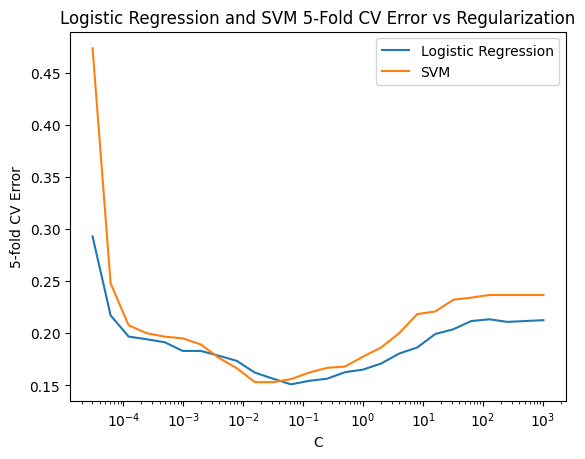

In [17]:
# plot the results
plt.plot(C_values, lr_k_error, label='Logistic Regression')
plt.plot(C_values, svm_k_error, label='SVM')
plt.xscale('log')
plt.xlabel('C')
plt.ylabel('5-fold CV Error')
plt.title('Logistic Regression and SVM 5-Fold CV Error vs Regularization')
plt.legend()
plt.show()

In [40]:
# Experiment 3B: Test error given optimal C values for LR and SVM
from sklearn.metrics import log_loss

lrc = LR(penalty='l2', C=0.0625)
svmc = SVC(C=0.03125, kernel='linear')

lrc.fit(X_train, y_train)
svmc.fit(X_train, y_train)

print('Logistic Regression Test Error: {:.5f}'.format(1 - lrc.score(X_test, y_test)))
print('SVM Test Error: {:.5f}'.format(1 - svmc.score(X_test, y_test)))

lr_predictions = lrc.predict(X_test)
svm_predictions = svmc.predict(X_test)

lr_log_loss = log_loss(y_test, lr_predictions)
svm_log_loss = log_loss(y_test, svm_predictions)

confidence = np.average(np.subtract(lr_predictions, svm_predictions))

print('Confidence: {:.5f}'.format(confidence))

Logistic Regression Test Error: 0.15800
SVM Test Error: 0.15500
Confidence: 2.21200


Since the confidence is positive, we can conclude that the second hypothesis, provided by the SVM, is more accurate than the first hypothesis, provided by the logistic regression.

In [44]:
# Experiment 4: Effects of Regularization and Bandwidth on Gaussian Kernel SVM
# This experiment will search for the best C-value and gamma-value pair, creating a
# Gaussian kernel SVM model for each pair and evaluating its accuracy using 5-fold
# cross on training and scored on a test sets.

gamma_naught = 1
beta = 2
gamma_values = [gamma_naught * pow(beta, i) for i in range(-16, 5)]

C_naught = 1
alpha = 2
C_values = [C_naught * pow(alpha, i) for i in range(-10, 10)]

g_c_pairs = []

for g in gamma_values:
    accuracies = {}
    for c in C_values:
        svmc = SVC(C=c, kernel='rbf', gamma=g)
        svmc.fit(X_train, y_train)
        error = kfold_cv(X_train, y_train, 5, svmc)
        accuracies[c] = error
    best_c = min(accuracies, key=accuracies.get)
    g_c_pairs.append((g, best_c))

# Score each of the models
print(g_c_pairs)

[(1.52587890625e-05, 512.0), (3.0517578125e-05, 512.0), (6.103515625e-05, 256.0), (0.0001220703125, 128.0), (0.000244140625, 64.0), (0.00048828125, 32.0), (0.0009765625, 16.0), (0.001953125, 8.0), (0.00390625, 8.0), (0.0078125, 4.0), (0.015625, 8.0), (0.03125, 4.0), (0.0625, 8.0), (0.125, 2.0), (0.25, 2.0), (0.5, 2.0), (1.0, 2.0), (2.0, 0.0009765625), (4.0, 0.0009765625), (8.0, 0.0009765625), (16.0, 0.0009765625)]


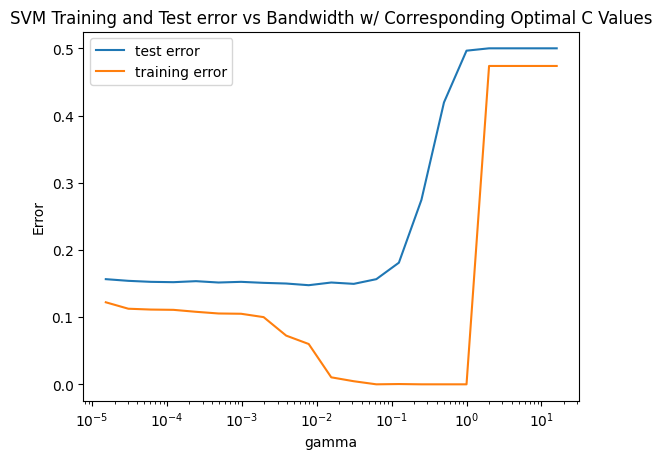

In [45]:
svm_test_accuracies = []
svm_train_accuracies = []
for g, c in g_c_pairs:
    svmc = SVC(C=c, kernel='rbf', gamma=g)
    svmc.fit(X_train, y_train)
    svm_test_accuracies.append(1 - svmc.score(X_test, y_test))
    svm_train_accuracies.append(1 - svmc.score(X_train, y_train))

# Plot the accuracies
plt.plot(gamma_values, svm_test_accuracies, label='test error')
plt.plot(gamma_values, svm_train_accuracies, label='training error')
plt.xscale('log')
plt.xlabel('gamma')
plt.ylabel('Error')
plt.title('SVM Training and Test Error vs. Bandwidth w/ Corresponding Optimal C Values')
plt.legend()
plt.show()

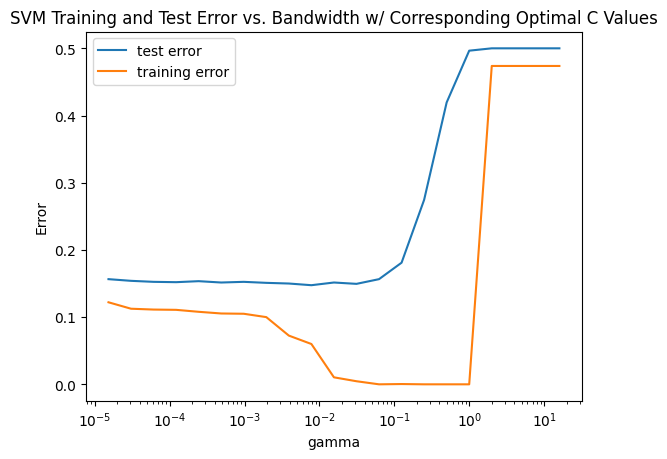

In [46]:
# Plot the accuracies
plt.plot(gamma_values, svm_test_accuracies, label='test error')
plt.plot(gamma_values, svm_train_accuracies, label='training error')
plt.xscale('log')
plt.xlabel('gamma')
plt.ylabel('Error')
plt.title('SVM Training and Test Error vs. Bandwidth w/ Corresponding Optimal C Values')
plt.legend()
plt.show()

In [47]:
# Find the gamma value assosciated with the minimum error
svm_min_error = min(svm_test_accuracies)
svm_min_gamma = gamma_values[svm_test_accuracies.index(svm_min_error)]

# Find the C value corresponding to the minimum error
svm_min_c = g_c_pairs[svm_test_accuracies.index(svm_min_error)][1]

print('SVM Minimum Error: ', svm_min_error)
print('SVM Gamma Value: ', svm_min_gamma)
print('SVM C Value: ', svm_min_c)

SVM Minimum Error:  0.14749999999999996
SVM Gamma Value:  0.0078125
SVM C Value:  4.0
